# Multi Location

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from typing import Callable, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [17]:
from models.handnet_based_model import handnet_based_model
from util.training import init_device
from util.training.dataloader import split_data_for_multiple_location, concat_and_shuffle
from util.training.metrics import IntersectionOverUnion, MeanPixelAccuracy

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


# 準備
---

## デバイスの初期化

In [5]:
!nvidia-smi

Tue Nov 26 23:28:44 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:18:00.0 Off |                  Off |
| 30%   28C    P8    17W / 300W |     60MiB / 48682MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:3B:00.0 Off |                  Off |
| 30%   

In [6]:
# 使用するGPUを指定
gpu = [2]

In [7]:
seed = 42
init_device(seed, gpu)

Setting random seed: 42
Random seed set for Python, NumPy, and TensorFlow.
Detected 5 GPU(s): ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
Visible GPU devices (1): ['/physical_device:GPU:2']


## ハイパーパラメータクラスの定義

In [8]:
@dataclass
class HyperParameters:
    epochs: int
    batch_size: int
    loss_function: Callable
    metrics: List[Callable]
    optimizer: Callable

## モデルの初期化関数の定義

In [9]:
def init_model(hparam):
    model = handnet_based_model(
        input_shape = (10, 52, 2),
        num_block1 = 3,
        num_block2 = 3,
        num_residual_blocks = 14, # 残差ブロックは増やすと重くなる
    )
    
    model.compile(
        optimizer = hparam.optimizer,
        loss = hparam.loss_function,
        metrics = hparam.metrics,
    )

    return model

## コールバック準備関数の定義

In [10]:
def prepare_callbacks(hparam, log_dirpath):

    callbacks = [
        TensorBoard(log_dir=log_dirpath, histogram_freq=1),
        EarlyStopping(
            monitor='val_iou',
            mode='max',
            patience=10,
            restore_best_weights=True,
        )
    ]

    return callbacks

## モデルを訓練する関数の定義

In [15]:
def train(hparam, train_data, valid_data, log_dirpath):
    print(f'log_dir = {log_dirpath}')

    X_train, Y_train = train_data
    X_valid, Y_valid = valid_data

    # モデルを作成
    model = init_model(hparam)

    # モデルのフィッティング
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_valid, Y_valid),
        epochs = hparam.epochs,
        batch_size = hparam.batch_size,
        verbose = 1,
        callbacks = prepare_callbacks(hparam, log_dirpath)
    )

    return history, model

# モデルの訓練
---

In [12]:
def get_log_dirpath(root_log_dirpath, notebook_name):
    date = datetime.now().strftime("%Y-%m-%d")
    time = datetime.now().strftime("%H-%M-%S")
    log_dirpath = os.path.join(
        root_log_dirpath, 
        date,
        notebook_name,
        time
    )

    return log_dirpath

In [20]:
# データをロード
csi_preprocess_id = 'real_and_imag'
train_location_list = ['511', '512', '514B']

dataset_dict = split_data_for_multiple_location(csi_preprocess_id, location_list)
train_data_dict, valid_data_dict, test_data_dict = dataset_dict

train_data = concat_and_shuffle(train_data_dict, train_location_list)
valid_data = concat_and_shuffle(valid_data_dict, train_location_list)

# ハイパーパラメータの指定
hparam = HyperParameters(
    epochs = 150,
    batch_size = 64,
    optimizer = Adam(learning_rate=0.001),
    loss_function = BinaryFocalCrossentropy(gamma=2), # BinaryCrossentropy(),
    metrics = [IntersectionOverUnion(threshold=0.5), MeanPixelAccuracy()],
)

# ログディレクトリを指定
project_dirpath = Path('/tf/workspace/deformation-prediction-multi-environment')
root_log_dirpath = project_dirpath/'logs' 
notebook_name = f'multi_location_real_and_imag'
log_dirpath = get_log_dirpath(root_log_dirpath, notebook_name)

history, model = train(hparam, train_data, valid_data, log_dirpath)

log_dir = /tf/workspace/deformation-prediction-multi-environment/logs/2024-11-26/multi_location_real_and_imag/23-31-11
Epoch 1/150


2024-11-26 23:31:33.957744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-11-26 23:31:36.606628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-26 23:31:36.975223: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7e7801ec50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-26 23:31:36.975279: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-26 23:31:36.985734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-26 23:31:37.156431: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

394/394 [==============================] - 92s 114ms/step - loss: 0.0961 - iou: 0.2350 - mpa: 0.6153 - val_loss: 0.0963 - val_iou: 0.2419 - val_mpa: 0.6191
Epoch 2/150
394/394 [==============================] - 43s 109ms/step - loss: 0.0918 - iou: 0.2560 - mpa: 0.6266 - val_loss: 0.1001 - val_iou: 0.2607 - val_mpa: 0.6283
Epoch 3/150
394/394 [==============================] - 43s 109ms/step - loss: 0.0897 - iou: 0.2839 - mpa: 0.6413 - val_loss: 0.1090 - val_iou: 0.2602 - val_mpa: 0.6273
Epoch 4/150
394/394 [==============================] - 43s 110ms/step - loss: 0.0874 - iou: 0.3219 - mpa: 0.6613 - val_loss: 0.1079 - val_iou: 0.3195 - val_mpa: 0.6611
Epoch 5/150
394/394 [==============================] - 43s 110ms/step - loss: 0.0851 - iou: 0.3530 - mpa: 0.6778 - val_loss: 0.1129 - val_iou: 0.3242 - val_mpa: 0.6628
Epoch 6/150
394/394 [==============================] - 43s 109ms/step - loss: 0.0825 - iou: 0.3842 - mpa: 0.6945 - val_loss: 0.1035 - val_iou: 0.3131 - val_mpa: 0.6559
Epoc

# ファインチューニング

# 評価
---

In [287]:
import seaborn as sns

In [256]:
X_train, Y_train = train_data
X_valid, Y_valid = valid_data
# X_test, Y_test = test_data_dict['512']
X_test, Y_test = concat_and_shuffle(test_data_dict, ['511', '512', '514B'])

In [282]:
X_train.shape

(25200, 10, 52, 2)

<AxesSubplot: >

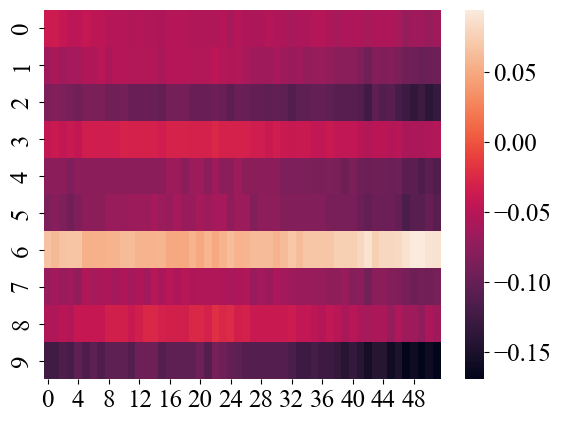

In [299]:
sns.heatmap(X_train[4000, :, :, 0])

## 各メトリックの平均値

In [257]:
results = model.evaluate(X_test, Y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.04f}")

169/169 [==============================] - 2s 14ms/step - loss: 0.1376 - iou: 0.3292 - mpa: 0.6599
loss: 0.1376
iou: 0.3292
mpa: 0.6599


# 予測結果のサンプルをランダムに表示

In [258]:
from util.plot import plot_predictions

In [259]:
metrics = {'IoU': IntersectionOverUnion(threshold=0.5), 'mPA': MeanPixelAccuracy()}

169/169 [==============================] - 2s 12ms/step


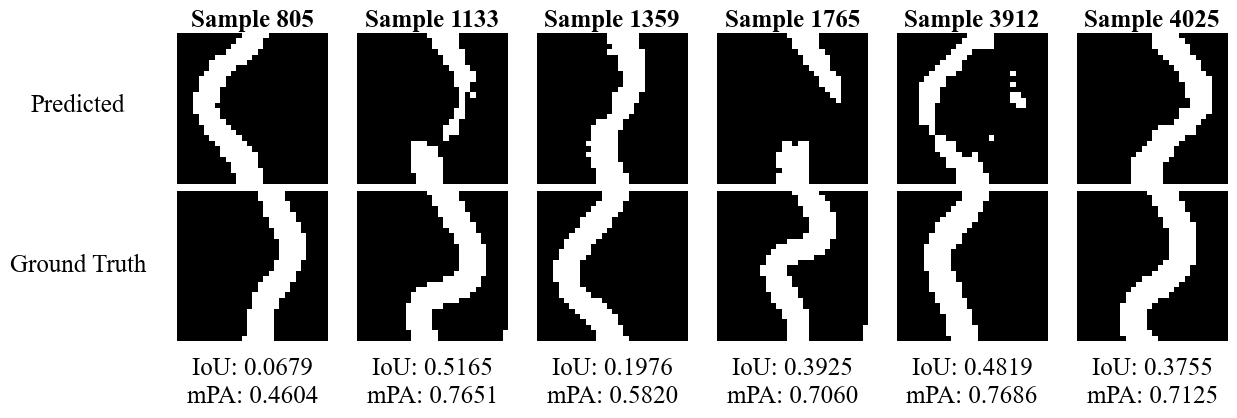

In [260]:
# テストセット
plot_predictions(model, X_test, Y_test, n_samples=6, threshold=0.5, seed=44, metrics=metrics)

# ベースラインとの比較

## ベースライン：Straight

In [261]:
def get_baseline_straight(n_sample, thickness=7):
    # 28x28の黒い画像（全ての値が0）
    image = np.zeros((28, 28))
    
    # 中心に指定された太さの白い線を入れる
    center = 28 // 2
    half_thickness = thickness // 2

    # 縦線を引く
    image[:, center - half_thickness:center + half_thickness + 1] = 1

    return np.tile(image, (n_sample, 1, 1))

In [262]:
baseline_straight = get_baseline_straight(Y_test.shape[0])
baseline_straight.shape

(5400, 28, 28)

(-0.5, 27.5, 27.5, -0.5)

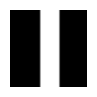

In [263]:
plt.figure(figsize=(1,1))
plt.imshow(baseline_straight[0], cmap='gray')
plt.axis('off')

## ベースライン：Average

In [264]:
def get_baseline_average(labels, n_sample, threshold=0.5):
    mean_array = np.mean(labels, axis=0)
    binary_array = (mean_array >= threshold).astype(int)
    
    return np.tile(binary_array, (n_sample, 1, 1))

In [265]:
baseline_average = get_baseline_average(Y_train, Y_test.shape[0])

In [266]:
baseline_average.shape

(5400, 28, 28)

(-0.5, 27.5, 27.5, -0.5)

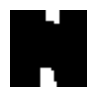

In [267]:
plt.figure(figsize=(1,1))
plt.imshow(baseline_average[0], cmap='gray')
plt.axis('off')

## ベースライン：Random

In [268]:
def get_baseline_random(labels, n_sample):
    # ランダムなインデックスを取得（重複を許可）
    indices = np.random.choice(len(labels), size=n_sample, replace=True)
    
    # ランダムに選んだサンプルを返す
    return labels[indices]

In [269]:
baseline_random = get_baseline_random(Y_train, Y_test.shape[0])

In [270]:
baseline_random.shape

(5400, 28, 28)

(-0.5, 27.5, 27.5, -0.5)

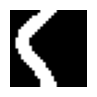

In [271]:
plt.figure(figsize=(1,1))
plt.imshow(baseline_random[0], cmap='gray')
plt.axis('off')

## ベースライン：Persistent

In [272]:
n_frames = 10
baseline_persistent = Y_test[:-n_frames]
print(baseline_persistent.shape, Y_test[n_frames:].shape)

(5390, 28, 28) (5390, 28, 28)


In [273]:
Y_pred = model.predict(X_test)

169/169 [==============================] - 2s 12ms/step


In [274]:
def calculate_metric_values(y_true, y_pred, metric):
    metric_values = []

    # メトリックオブジェクトの初期化
    for i in range(len(y_true)):
        metric.reset_state()  # 状態をリセット
        metric.update_state(y_true[i:i+1], y_pred[i:i+1])
        metric_value = metric.result().numpy().item()
        metric_values.append(metric_value)

    return metric_values

In [275]:
# IoUを計算
iou = IntersectionOverUnion(threshold=0.5)
iou_proposed = calculate_metric_values(Y_test, Y_pred, iou)
iou_baseline_straight = calculate_metric_values(Y_test, baseline_straight, iou)
iou_baseline_average = calculate_metric_values(Y_test, baseline_average, iou)
iou_baseline_random = calculate_metric_values(Y_test, baseline_random, iou)
iou_baseline_persistent = calculate_metric_values(Y_test[n_frames:], baseline_persistent, iou)

In [276]:
# 平均IoU
print(f'Proposed: {np.mean(iou_proposed):.3f}')
print(f'Straight: {np.mean(iou_baseline_straight):.3f}')
print(f'Average: {np.mean(iou_baseline_average):.3f}')
print(f'Random: {np.mean(iou_baseline_random):.3f}')
print(f'Persistent: {np.mean(iou_baseline_persistent):.3f}')

Proposed: 0.329
Straight: 0.298
Average: 0.232
Random: 0.287
Persistent: 0.823


In [277]:
# mPAを計算
mpa = MeanPixelAccuracy()
mpa_proposed = calculate_metric_values(Y_test, Y_pred, mpa)
mpa_baseline_straight = calculate_metric_values(Y_test, baseline_straight, mpa)
mpa_baseline_average = calculate_metric_values(Y_test, baseline_average, mpa)
mpa_baseline_random = calculate_metric_values(Y_test, baseline_random, mpa)
mpa_baseline_persistent = calculate_metric_values(Y_test[n_frames:], baseline_persistent, mpa)

In [278]:
# 平均mPA
print(f'Proposed: {np.mean(mpa_proposed):.3f}')
print(f'Straight: {np.mean(mpa_baseline_straight):.3f}')
print(f'Average: {np.mean(mpa_baseline_average):.3f}')
print(f'Random: {np.mean(mpa_baseline_random):.3f}')
print(f'Persistent: {np.mean(mpa_baseline_persistent):.3f}')

Proposed: 0.660
Straight: 0.655
Average: 0.613
Random: 0.629
Persistent: 0.918


In [279]:
from util.plot import plot_ecdf

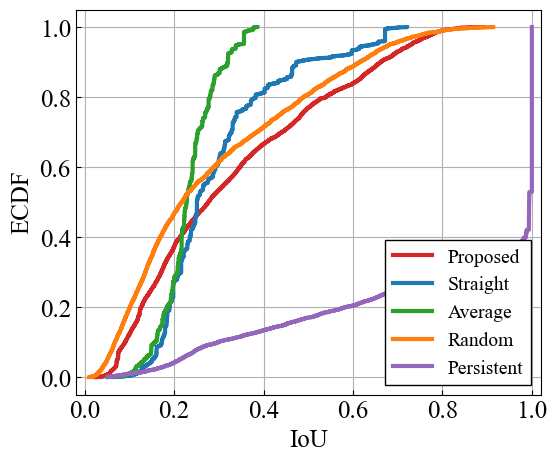

In [280]:
plot_ecdf(
    iou_proposed,
    [iou_baseline_straight, iou_baseline_average, iou_baseline_random, iou_baseline_persistent],
    ['Proposed', 'Straight', 'Average', 'Random', 'Persistent'],
    'IoU',
    'ECDF',
    filename=None,
    xlim=(-0.02, 1.02),
    legend_loc='lower right'
)

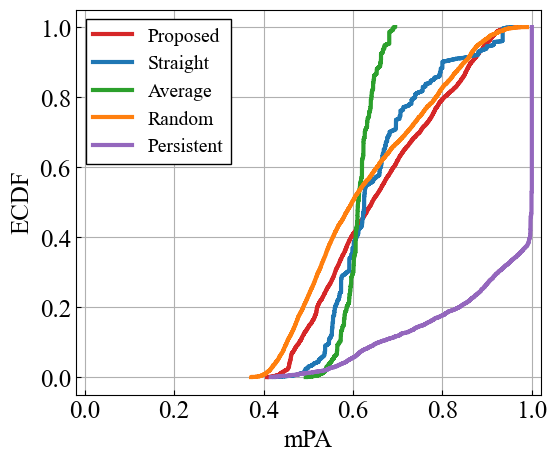

In [281]:
plot_ecdf(
    mpa_proposed,
    [mpa_baseline_straight, mpa_baseline_average, mpa_baseline_random, mpa_baseline_persistent],
    ['Proposed', 'Straight', 'Average', 'Random', 'Persistent'],
    'mPA',
    'ECDF',
    filename=None,
    xlim=(-0.02, 1.02),
    legend_loc='upper left'
)